# Model calibration using the trajectory

This is the module that using a predefined "trajectory" to tune 
parameters of mixed-in effect

<style>
    body {
        --vscode-font-family: "Lato"
    }
    h1, h2, h3 {
        
    }
</style>
<script src="https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.7/MathJax.js?config=TeX-MML-AM_CHTML">
</script>
<script src="https://cdn.plot.ly/plotly-2.6.3.min.js"></script>

## Initialization

In [2]:
ENV["CRIMINOS_CONF"] = "confs/conf_single_nij.yaml"
ENV["CRIMINOS_ALIAS"] = "test"
Base.istextmime(::MIME"application/vnd.plotly.v1+json") = true
using Revise
using ForwardDiff
using LinearAlgebra
using Random
using Printf
using LaTeXStrings
using JuMP
using Criminos
using Plots
using Gurobi
using ProgressMeter
using ColorSchemes

using CSV, Tables, DataFrames, YAML

include("./conf.jl")
include("./tools.jl")

# yaml = YAML.load_file("ipynb/nij-simulation.0.15.yaml")
# yaml = yaml2 = YAML.load_file("ipynb/nij-simulation.0.15.yaml")
yaml = yaml2 = YAML.load_file("ipynb/nij-simulation.yaml")


# maximum number of time periods used in the estimation
Tₘ = 50

data_fixed = AgentData(yaml, Tₘ)
data_simulation = AgentData(yaml2, Tₘ; n=data_fixed.n)

Cardinal Optimizer v7.0.6. Build date Jan 16 2024
Copyright Cardinal Operations 2023. All Rights Reserved
--------------------------------------------------------------------------------
config_dir: confs/conf_single_nij.yaml
result_dir: result-20241108/test
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Simulation Style Configs:

--------------------------------------------------------------------------------
total number of slots: 18


OrderedCollections.OrderedDict{Any, Any} with 23 entries:
  "R"                            => 1
  "bool_compute"                 => false
  "bool_conv"                    => true
  "bool_init"                    => true
  "bool_plot_surface"            => false
  "bool_plot_trajectory"         => false
  "bool_use_html"                => true
  "group_montonicity"            => [0, 0]
  "group_new_ratio"              => [1, 4]
  "group_size"                   => [1, 6]
  "output_dir"                   => "result-20241108/test"
  "seed_number"                  => 1
  "style_correlation"            => "nothing"
  "style_correlation_psd"        => true
  "style_correlation_seed"       => "rand"
  "style_correlation_subp"       => false
  "style_decision"               => "decision_identity!"
  "style_mixin"                  => "mixed_in_gnep_best!"
  "style_mixin_monotonicity"     => 2
  ⋮                              => ⋮

┌ Info: size corrected to
│   this.n = 17
└ @ Main /Users/brent/Library/Mobile Documents/com~apple~CloudDocs/Documents/recherche/docs-fairness/Criminos.jl/tools.jl:185
┌ Info: size corrected to
│   this.n = 17
└ @ Main /Users/brent/Library/Mobile Documents/com~apple~CloudDocs/Documents/recherche/docs-fairness/Criminos.jl/tools.jl:209


AgentData{Vector{Float64}, Matrix{Float64}}(17, 50, [0.781, 0.781, 0.781, 0.781, 0.781, 0.781, 0.781, 0.781, 0.781, 0.781, 0.781, 0.781, 0.781, 0.781, 0.781, 0.781, 0.781], [230.0, 213.0, 308.0, 238.0, 255.0, 226.0, 228.0, 230.0, 216.0, 195.0, 187.0, 179.0, 140.0, 102.0, 44.0, 13.0, 1.0], [1382.0 1119.0 … 631.9 628.9; 1278.0 1216.7 … 821.5 817.2; … ; 77.0 130.1 … 268.6 270.7; 8.0 33.6 … 155.4 157.7], [1382.0 1067.6132312749673 … 598.0 590.8709321702464; 1278.0 1150.6856833709535 … 752.6142249807698 737.9545584907246; … ; 77.0 108.40645257225088 … 230.55318673002955 215.12221666888826; 8.0 22.601818332105985 … 146.085495182244 125.49922361184437], [1382.0 1170.3867687250327 … 665.8 666.9290678297535; 1278.0 1282.7143166290466 … 890.3857750192302 896.4454415092755; … ; 77.0 151.7935474277491 … 306.6468132699705 326.2777833311117; 8.0 44.59818166789402 … 164.71450481775602 189.9007763881556], [254.1 213.1 … 116.8 115.1; 248.6 237.1 … 164.3 160.6; … ; 38.4 60.4 … 106.5 111.9; 3.3 18.3 … 62

In [3]:
data_simulation.γ

17-element Vector{Float64}:
 0.781
 0.781
 0.781
 0.781
 0.781
 0.781
 0.781
 0.781
 0.781
 0.781
 0.781
 0.781
 0.781
 0.781
 0.781
 0.781
 0.781

## Start

> agent-based simulation results

In [4]:
n = data_fixed.n

17

In [5]:
data_fixed.traj_x

17×50 Matrix{Float64}:
 1382.0  1119.0   937.2   826.1   745.0  …   629.7   633.4   631.9   628.9
 1278.0  1216.7  1146.7  1072.9  1003.5      821.3   814.6   821.5   817.2
 1849.0  1609.7  1471.8  1380.2  1306.7     1106.2  1106.5  1097.7  1109.7
 1429.0  1401.0  1333.4  1273.3  1234.6     1048.8  1060.6  1060.4  1046.4
 1530.0  1411.1  1335.8  1276.6  1233.6     1070.9  1067.2  1083.1  1083.0
 1358.0  1306.1  1253.6  1207.6  1167.0  …  1028.8  1017.9  1009.3  1022.8
 1368.0  1284.7  1216.4  1175.2  1137.0     1001.9  1001.8  1001.5   993.3
 1377.0  1280.5  1223.2  1181.6  1139.2     1017.2  1012.6  1001.6   993.9
 1294.0  1224.2  1171.6  1126.1  1088.7      966.0   971.9   969.5   970.9
 1170.0  1144.5  1091.8  1034.1  1010.3      917.3   911.1   919.4   911.3
 1122.0  1083.0  1059.1  1028.1   988.7  …   872.2   878.8   884.3   897.8
 1074.0  1006.2   963.4   945.9   926.0      826.2   826.5   824.7   832.2
  838.0   855.0   850.0   836.9   833.5      736.7   746.9   733.8   734.7
  

### Initialization and override the parameters of $\Psi$

In [6]:
data = data_fixed
include("./init.jl")
# baseline policy
for _z in vec_z
    _z.τ .= 0.3
end
vec_Ψ[1].γ = data.γ
vec_Ψ[1].λ = data.λ
# vec_Ψ[1].λ[1] = 497.26
vec_Ψ[1].Γ = diagm(data.γ)
vec_Ψ[1].Γₕ = vec_Ψ[1].M * vec_Ψ[1].Γ
vec_z[1].x .= data.traj_x[:, 1]
vec_z[1].x₋ .= data.traj_x[:, 1]
vec_z[1].y = data.traj_y[:, 1]

17-element Vector{Float64}:
 254.1
 248.6
 431.4
 377.6
 429.0
 405.8
 416.9
 451.7
 456.2
 413.2
 392.2
 396.6
 311.0
 247.1
 113.8
  38.4
   3.3

In [7]:
Criminos.default_barrier_option.μ

0.01

## Fitting

In [8]:
_args = (ω∇ω, G, md, _H, _g) = fit_trajectory(data, vec_Ψ)

Setting parameter 'RelGap' to 0.01
Setting parameter 'FeasTol' to 0.0001
Setting parameter 'DualTol' to 0.0001
Model fingerprint: 63ce0135

Using Cardinal Optimizer v7.0.6 on macOS (aarch64)
Hardware has 8 cores and 8 threads. Using instruction set ARMV8 (30)
Maximizing an SDP problem

The original problem has:
    2516 rows, 6817 columns and 9996 non-zero elements
    2 PSD columns
    1 PSD objective elements
    153 PSD constraints

Using Primal-Dual Method

Starting barrier solver using 8 threads

Problem info:
Range of matrix coefficients:    [9e-03,1e+00]
Range of rhs coefficients:       [2e-02,2e-02]
Range of bound coefficients:     [0e+00,0e+00]
Range of cost coefficients:      [5e-03,2e+03]

Factor info:
Number of dense columns:         0
Number of matrix entries:        3.125e+04
Number of factor entries:        3.623e+04
Number of factor flops:          1.759e+06

Iter       Primal.Obj         Dual.Obj      Compl  Primal.Inf  Dual.Inf    Time
   0  -5.23823863e+02  +0.000000

(Criminos.var"#ω∇ω#154"{Vector{Float64}, Matrix{Float64}}([-5861.962004190216, -2873.0452116082515, -11510.313040255727, -6648.53828363987, -8548.090318834016, -6104.773333460724, -7471.815478476468, -11106.784807253049, -9962.619677749855, -6822.523400114951, -7626.189521528035, -7536.535145716908, -3546.4738789268904, -5024.817727850544, 3907.2999286256863, 1645.9558549270816, 1030.9756613648408], [20.449311406155424 -0.38960857247738134 … -2.147719248660426 6.128822316541931; -0.38960857247738134 17.9334867968549 … -0.2607502132673351 5.667179644138676; … ; -2.147719248660426 -0.2607502132673351 … 17.05659951962073 -3.5241333995741515; 6.128822316541931 5.667179644138676 … -3.5241333995741515 29.831524752328537]), sparse([1, 2, 1, 2, 3, 2, 3, 4, 3, 4  …  14, 15, 14, 15, 16, 15, 16, 17, 16, 17], [1, 1, 2, 2, 2, 3, 3, 3, 4, 4  …  14, 14, 15, 15, 15, 16, 16, 16, 17, 17], [5.570420091324201, -2.7852100456621005, -2.7852100456621005, 5.570420091324201, -2.7852100456621005, -2.78521004566

In [9]:
_H, _g

([20.449311406155424 -0.38960857247738134 … -2.147719248660426 6.128822316541931; -0.38960857247738134 17.9334867968549 … -0.2607502132673351 5.667179644138676; … ; -2.147719248660426 -0.2607502132673351 … 17.05659951962073 -3.5241333995741515; 6.128822316541931 5.667179644138676 … -3.5241333995741515 29.831524752328537], [-5861.962004190216, -2873.0452116082515, -11510.313040255727, -6648.53828363987, -8548.090318834016, -6104.773333460724, -7471.815478476468, -11106.784807253049, -9962.619677749855, -6822.523400114951, -7626.189521528035, -7536.535145716908, -3546.4738789268904, -5024.817727850544, 3907.2999286256863, 1645.9558549270816, 1030.9756613648408])

## Using fitted params at fixed control $\tau$

In [10]:
Fp(vec_z) = F!(
    vec_z, vec_Ψ;
    fₜ=Criminos.decision_identity!, targs=(cₜ, cc.τₗ, cc.τₕ),
    fₘ=cc.style_mixin, margs=_args,
)
kₑ, ε, traj, bool_opt = Criminos.simulate(
    vec_z, vec_Ψ, Fp; K=K,
    metrics=metrics,
    tol=1e-7
);

Progress:   0%|                                         |  ETA: 0:22:03┌ Info: converged in 201 steps
└ @ Criminos /Users/brent/Library/Mobile Documents/com~apple~CloudDocs/Documents/recherche/docs-fairness/Criminos.jl/src/Criminos.jl:162
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
┌ Info: final eps: 9.958088001851095e-8
└ @ Criminos /Users/brent/Library/Mobile Documents/com~apple~CloudDocs/Documents/recherche/docs-fairness/Criminos.jl/src/Criminos.jl:170


In [11]:
plot_convergence(ε, vec_z |> length)
# the equilibria
r = traj[end][1]

┌ Info: write to
│   "$(cc.result_dir)/convergence.$(format)" = result-20241108/test/convergence.html
└ @ Main /Users/brent/Library/Mobile Documents/com~apple~CloudDocs/Documents/recherche/docs-fairness/Criminos.jl/tools.jl:63


@current iterate 17 states:
   x: [658.8116, 801.5013, 1069.2933, 1055.8582, 1035.081, 1111.5344, 1039.3129, 914.6622, 1011.9515, 909.2658, 834.4091, 825.703, 722.6838, 647.694, 450.6047, 215.8092, 192.4577]
   x₋: [658.8116, 801.5013, 1069.2933, 1055.8582, 1035.081, 1111.5344, 1039.3129, 914.6622, 1011.9515, 909.2658, 834.4091, 825.703, 722.6837, 647.6941, 450.6047, 215.8092, 192.4576]
   ρ: [0.1666, 0.1968, 0.2359, 0.2471, 0.2871, 0.2473, 0.265, 0.3426, 0.3026, 0.3309, 0.3672, 0.3682, 0.3883, 0.3545, 0.3542, 0.5363, 0.3276]
   y: [109.757, 157.7355, 252.2615, 260.9261, 297.1838, 274.8713, 275.3713, 313.3854, 306.1928, 300.9057, 306.3659, 304.0241, 280.6339, 229.616, 159.6, 115.7304, 63.0438]
   ∑: 4007.6046/13496.6337
   τ: [0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3]
   I: [0.4249, 0.629, 0.1529, 0.5767, 0.7425, 0.8569, 0.0918, 0.2246, 0.7724, 0.9027, 0.7382, 0.1917, 0.169, 0.5535, 0.6951, 0.642, 0.1171]


#### Visualize

In [12]:
figs_vis = plot_fitting_results(data, r; bool_pdf=false);

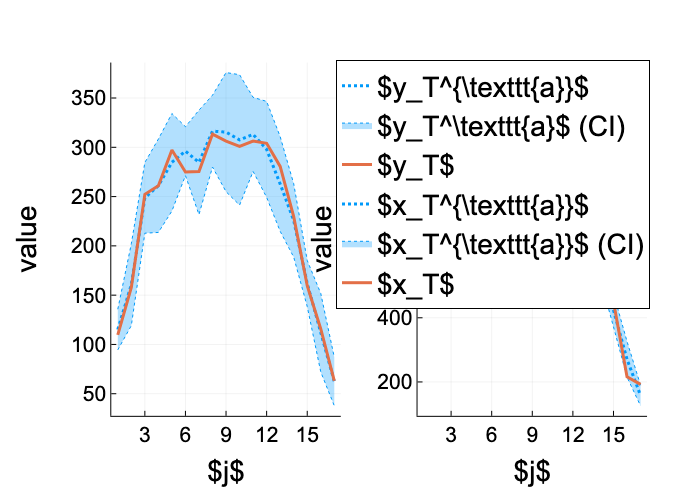

In [13]:
plot(figs_vis[1], figs_vis[2])

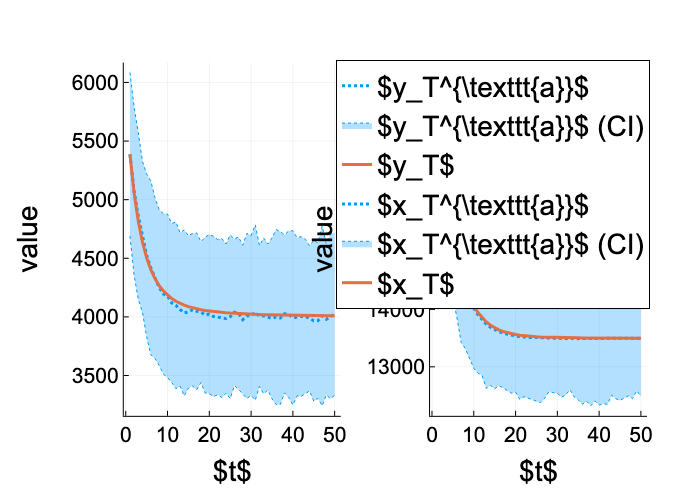

In [14]:
plot(figs_vis[3], figs_vis[4])

In [15]:
# savefig(fig, "nij-simulation-y.pdf")
# savefig(fig1, "nij-simulation-x.pdf")
# savefig(fig2, "nij-simulation-y-prog.pdf")
# savefig(fig3, "nij-simulation-x-prog.pdf")

## Dynamic control 

In [16]:
Fp(vec_z) = F!(
    vec_z, vec_Ψ;
    fₜ=Criminos.decision_priority_by_opt!, targs=(cₜ, cc.τₗ, cc.τₕ),
    fₘ=cc.style_mixin, margs=_args,
)
kₑ, ε, traj, bool_opt = Criminos.simulate(
    vec_z, vec_Ψ, Fp; K=K,
    metrics=metrics,
    tol=1e-7
);

Progress:   9%|███▋                                     |  ETA: 0:00:08┌ Info: converged in 201 steps
└ @ Criminos /Users/brent/Library/Mobile Documents/com~apple~CloudDocs/Documents/recherche/docs-fairness/Criminos.jl/src/Criminos.jl:162
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Info: final eps: 9.958088001851095e-8
└ @ Criminos /Users/brent/Library/Mobile Documents/com~apple~CloudDocs/Documents/recherche/docs-fairness/Criminos.jl/src/Criminos.jl:170


In [17]:
@info """sanity check 
$(abs.(Criminos.decision_priority!(traj[end][1], vec_Ψ[1]; args=(cₜ, cc.τₗ, cc.τₕ)) - traj[end][1].I) |> maximum)
"""

┌ Info: sanity check 
│ 6.30926926925568e-7
└ @ Main /Users/brent/Library/Mobile Documents/com~apple~CloudDocs/Documents/recherche/docs-fairness/Criminos.jl/jl-run-single-agent.ipynb:1


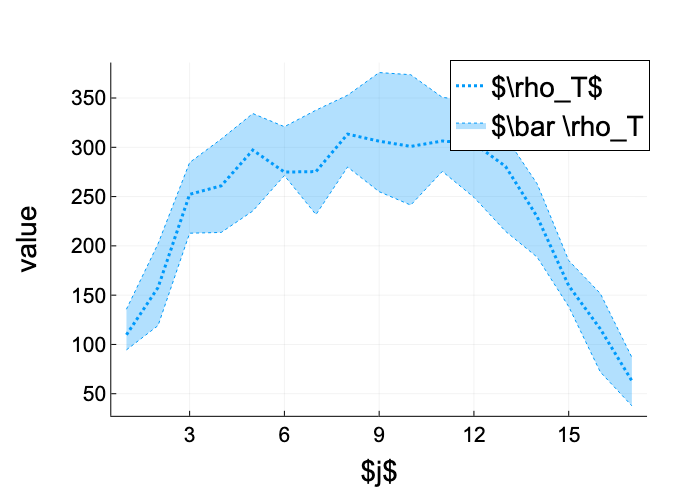

In [18]:
fig = generate_empty(cc.bool_use_html)
plot!(
    1:n, traj[end][1].y,
    labels=L"$\rho_T$",
    linestyle=:dot,
    color=series_color[1],
    linewidth=3,
)
plot!(
    1:n, data.traj_y_lb[:,end], fillrange=data.traj_y_ub[:,end],
    labels=L"$\bar \rho_T",
    fillalpha=0.3,
    linestyle=:dot,
    color=series_color[1],
)
fig

In [19]:
cc

Main.CriminosConfigs

In [ ]:
[traj[end][1].τ r.τ]